随机森林预测

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_predict

# 1. 读取数据，并进行基础数据清洗
df = pd.read_csv('country_inter_gen.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(), inplace=True)
# 如有必要，可以删除最后一行（例如部分列缺失）：
df = df.iloc[:-1, :]
df.head()

,A GDP,A Unemployment Rate,A Inflation Rate,A Foreign Debt,A Government Spending,A Military Spending,A Education Spending,A Health Spending,A Environment Spending,A Technology Investment,...,A Technology I,A Health I,B Political I,B Economic I,B Military I,B Diplomatic I,B Social I,B Environmental I,B Technology I,B Health I
0,14514.82,5.73,1.48,307.68,805.93,168.13,72.87,144.91,47.90,240.33,...,0,0,0,0,0,0,0,0,0,0
1,14463.09,5.52,-0.09,305.26,830.80,179.34,73.46,166.45,79.18,242.91,...,1,1,1,2,5,3,2,2,1,1
2,14225.03,5.07,-1.70,298.20,804.90,189.87,73.80,187.53,111.35,245.87,...,1,1,1,2,5,3,2,2,2,1
3,13776.89,4.42,-3.22,287.25,806.75,200.04,75.38,207.06,142.73,245.29,...,1,1,1,2,5,3,2,2,2,1
4,13483.10,3.56,-4.85,282.04,791.58,214.47,73.20,230.93,174.44,247.76,...,1,1,1,2,5,3,2,2,2,1


In [8]:

# 2. 定义特征和目标变量
# 假设目标变量为下面这些列，可根据实际情况调整
target_columns = [
    'A Political T', 'A Economic T', 'A Military T', 'A Diplomatic T',
    'A Social T', 'A Environmental T', 'A Technology T', 'A Health T',
    'A Political I', 'A Economic I', 'A Military I', 'A Diplomatic I',
    'A Social I', 'A Environmental I', 'A Technology I', 'A Health I'
]
X = df.drop(columns=target_columns)  # 特征变量
y = df[target_columns]               # 目标变量

# 3. 特征标准化：确保各特征数量级一致，有助于模型训练
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.describe()

,A GDP,A Unemployment Rate,A Inflation Rate,A Foreign Debt,A Government Spending,A Military Spending,A Education Spending,A Health Spending,A Environment Spending,A Technology Investment,...,B Technology T,B Health T,B Political I,B Economic I,B Military I,B Diplomatic I,B Social I,B Environmental I,B Technology I,B Health I
count,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,...,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02,5.210000e+02
mean,-1.091045e-16,-1.636567e-16,-1.091045e-16,2.182089e-16,-1.636567e-16,-2.182089e-16,-8.728356e-16,3.818656e-16,2.727611e-16,1.091045e-16,...,2.182089e-16,5.455223e-17,1.186511e-15,1.186511e-15,2.113899e-16,4.773320e-16,1.186511e-15,1.186511e-15,-6.716743e-16,1.186511e-15
std,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,...,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00,1.000961e+00
min,-1.929608e+00,-1.726391e+00,-1.725093e+00,-2.465022e+00,-2.917560e+00,-1.796658e+00,-2.324581e+00,-1.732141e+00,-1.729693e+00,-1.484257e+00,...,-1.576035e+00,-5.913890e-01,-2.280351e+01,-2.280351e+01,-2.280351e+01,-8.331247e+00,-2.280351e+01,-2.280351e+01,-2.039216e+01,-2.280351e+01
25%,-6.796744e-01,-8.628662e-01,-8.649997e-01,-6.806012e-01,-9.052199e-01,-8.684246e-01,-6.308606e-01,-8.580350e-01,-8.639108e-01,-9.033141e-01,...,-1.320793e+00,-5.913890e-01,4.385290e-02,4.385290e-02,4.385290e-02,-2.104244e-01,4.385290e-02,4.385290e-02,5.888015e-02,4.385290e-02
50%,2.105510e-01,-4.228898e-03,-1.285528e-04,2.392571e-01,3.499006e-01,5.023618e-02,-4.352216e-02,-2.212818e-03,-4.715008e-04,-2.219533e-02,...,7.211449e-01,-5.913890e-01,4.385290e-02,4.385290e-02,4.385290e-02,-2.104244e-01,4.385290e-02,4.385290e-02,5.888015e-02,4.385290e-02
75%,6.672154e-01,8.631480e-01,8.641609e-01,7.890934e-01,8.657680e-01,8.567795e-01,5.385628e-01,8.630197e-01,8.647764e-01,8.693506e-01,...,7.211449e-01,1.690934e+00,4.385290e-02,4.385290e-02,4.385290e-02,-2.104244e-01,4.385290e-02,4.385290e-02,5.888015e-02,4.385290e-02
max,2.006486e+00,1.700992e+00,1.730943e+00,1.730779e+00,1.538823e+00,1.685194e+00,2.146126e+00,1.725161e+00,1.728850e+00,1.781591e+00,...,7.211449e-01,1.690934e+00,4.385290e-02,4.385290e-02,4.385290e-02,3.849987e+00,4.385290e-02,4.385290e-02,5.888015e-02,4.385290e-02


In [21]:
# 4. 定义交叉验证策略：使用 KFold，并打乱数据以确保每个折都具备足够的多样性
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
# 5. 构建随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 6. 利用 cross_val_predict 对全数据集进行交叉验证预测
# 这样每个样本都有预测结果，避免了固定划分导致部分折中目标变量方差为0的情况
y_pred_cv = cross_val_predict(rf_model, X_scaled, y, cv=cv)


In [23]:
# 7. 计算整体评估指标
mse_cv = mean_squared_error(y, y_pred_cv)
mae_cv = mean_absolute_error(y, y_pred_cv)
r2_cv = r2_score(y, y_pred_cv, multioutput='uniform_average')
ev_cv = explained_variance_score(y, y_pred_cv, multioutput='uniform_average')

print("Cross-Validation Mean Squared Error:", mse_cv)
print("Cross-Validation R² Score:", r2_cv)
print("Cross-Validation Mean Absolute Error:", mae_cv)
print("Cross-Validation Explained Variance:", ev_cv)

# 8. 针对每个目标变量分别评估
print("\nIndividual evaluation metrics for each target:")
for col_idx, col in enumerate(y.columns):
    r2_col = r2_score(y[col], y_pred_cv[:, col_idx])
    mae_col = mean_absolute_error(y[col], y_pred_cv[:, col_idx])
    mse_col = mean_squared_error(y[col], y_pred_cv[:, col_idx])
    print(f"{col} -> R²: {r2_col:.4f}, MAE: {mae_col:.4f}, MSE: {mse_col:.4f}")

Cross-Validation Mean Squared Error: 0.0923366722648753
Cross-Validation R² Score: 0.34937474913455113
Cross-Validation Mean Absolute Error: 0.04380638195777353
Cross-Validation Explained Variance: 0.3497494177119028

Individual evaluation metrics for each target:
A Political T -> R²: 0.9867, MAE: 0.0370, MSE: 0.1395
A Economic T -> R²: 0.9388, MAE: 0.0800, MSE: 0.2245
A Military T -> R²: -0.0793, MAE: 0.0164, MSE: 0.0744
A Diplomatic T -> R²: 0.9930, MAE: 0.0584, MSE: 0.2079
A Social T -> R²: 1.0000, MAE: 0.0000, MSE: 0.0000
A Environmental T -> R²: -0.0793, MAE: 0.0109, MSE: 0.0331
A Technology T -> R²: 0.9785, MAE: 0.0158, MSE: 0.0310
A Health T -> R²: 0.4539, MAE: 0.4332, MSE: 0.6647
A Political I -> R²: -0.0793, MAE: 0.0027, MSE: 0.0021
A Economic I -> R²: -0.0793, MAE: 0.0055, MSE: 0.0083
A Military I -> R²: -0.0793, MAE: 0.0136, MSE: 0.0517
A Diplomatic I -> R²: -0.0793, MAE: 0.0082, MSE: 0.0186
A Social I -> R²: -0.0793, MAE: 0.0055, MSE: 0.0083
A Environmental I -> R²: -0.0793

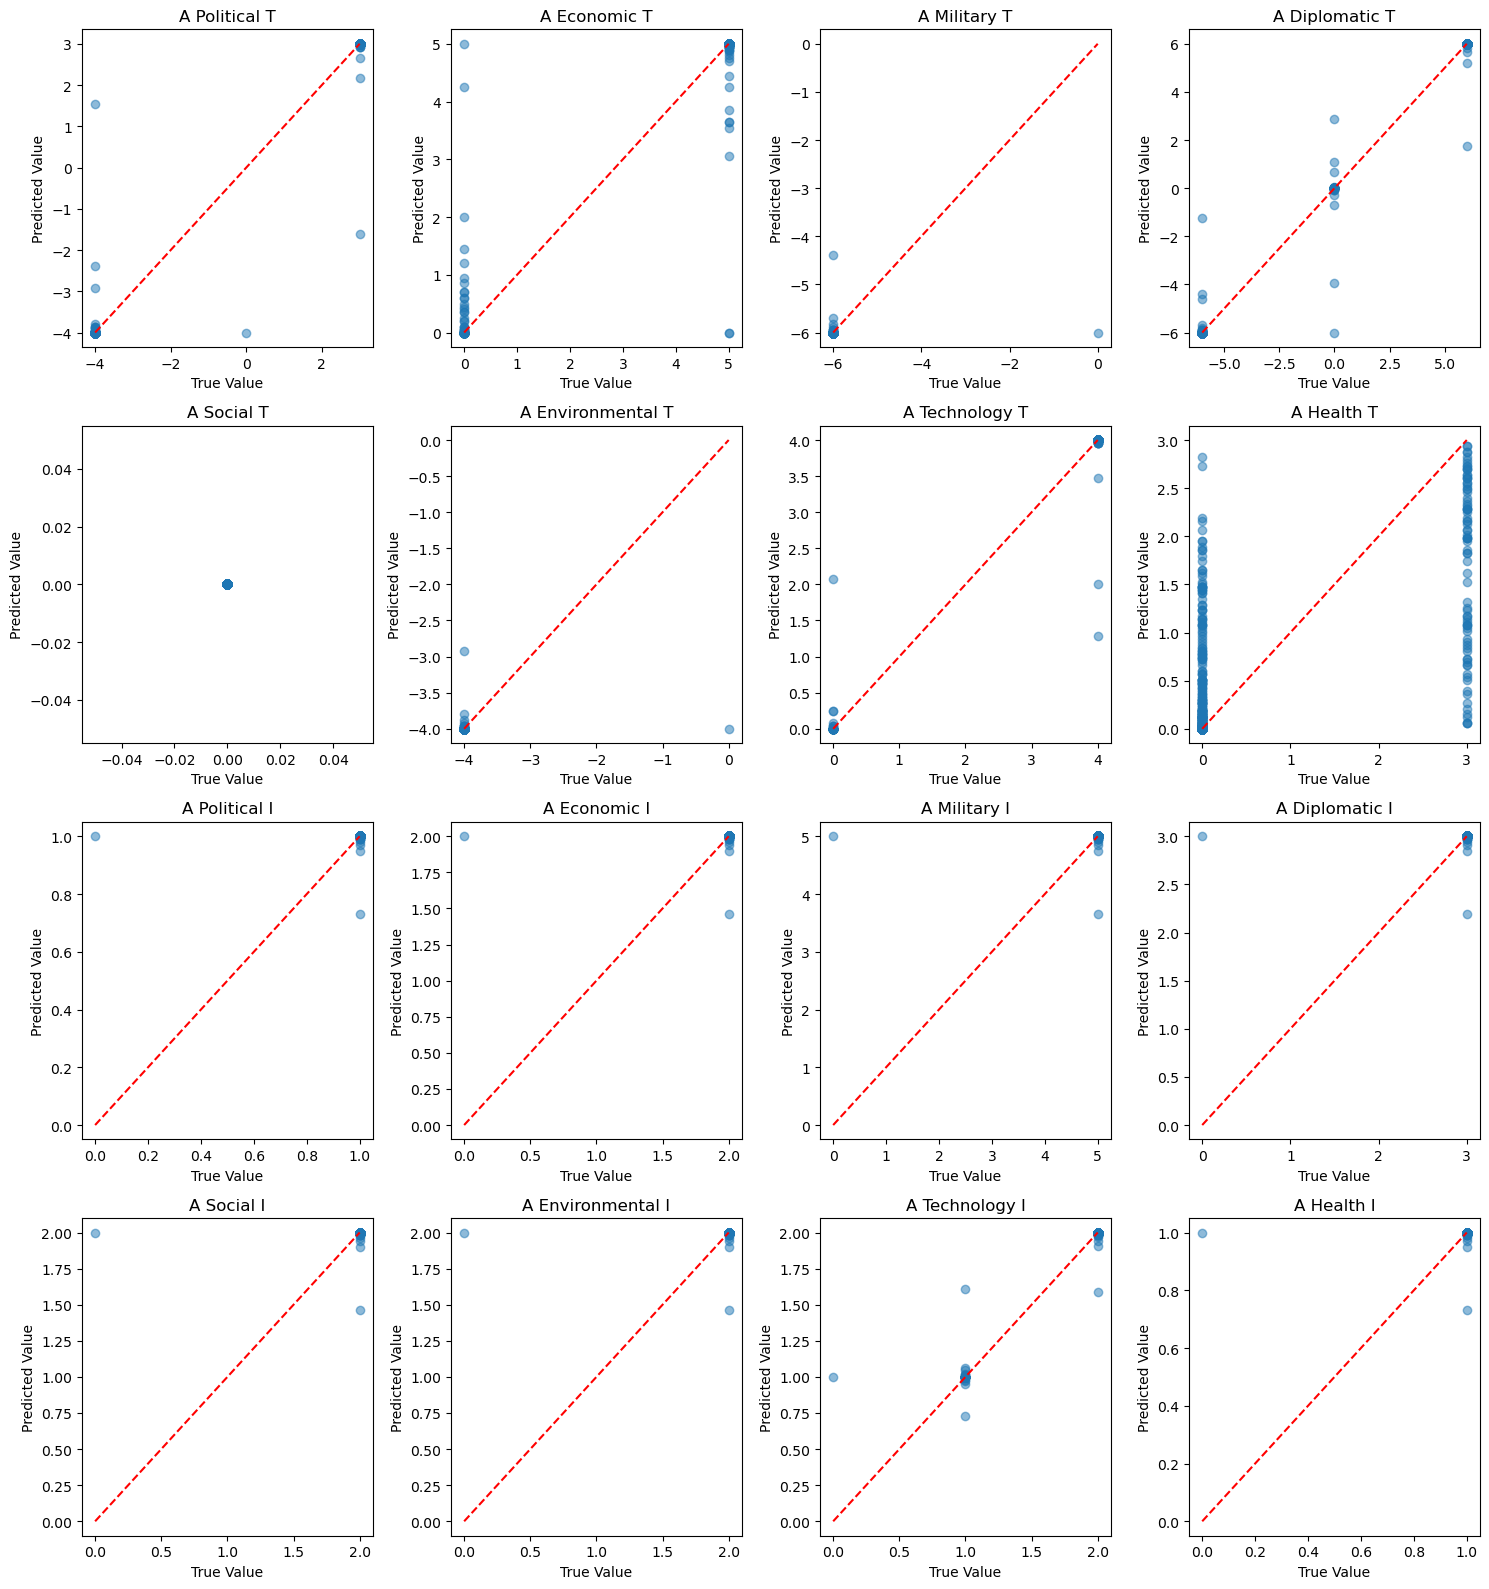

In [24]:
# 9. 可视化：绘制每个目标变量的预测值与真实值的散点图
n_targets = len(y.columns)
n_cols = 4  # 每行显示4个子图
n_rows = int(np.ceil(n_targets / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(y.columns):
    axes[i].scatter(y[col], y_pred_cv[:, i], alpha=0.5)
    axes[i].set_title(col)
    axes[i].set_xlabel("True Value")
    axes[i].set_ylabel("Predicted Value")
    # 绘制参考线 y = x
    min_val = min(y[col].min(), y_pred_cv[:, i].min())
    max_val = max(y[col].max(), y_pred_cv[:, i].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--')

# 删除多余的子图（如果有）
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()